In [1]:
from  skimage.io import imread, imshow
import pywt
import pywt.data
import matplotlib.pyplot as plt
import numpy as np
import glob
import gmm
from tqdm import tqdm
import json
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Obtener datos procesados

## Obtener todas las imagenes

In [4]:
rutas_imagenes = glob.glob(f'./imagenes/*.png', recursive=True)
print(rutas_imagenes)

['./imagenes/S060_003_00000018.png', './imagenes/S147_002_00000011.png', './imagenes/S071_004_00000028.png', './imagenes/S042_004_00000019.png', './imagenes/S106_004_00000008.png', './imagenes/S148_002_00000014.png', './imagenes/S077_001_00000028.png', './imagenes/S501_004_00000056.png', './imagenes/S101_002_00000018.png', './imagenes/S131_006_00000022.png', './imagenes/S026_006_00000011.png', './imagenes/S085_003_00000011.png', './imagenes/S078_001_00000032.png', './imagenes/S116_001_00000013.png', './imagenes/S022_005_00000031.png', './imagenes/S119_008_00000018.png', './imagenes/S082_001_00000014.png', './imagenes/S137_005_00000027.png', './imagenes/S113_001_00000012.png', './imagenes/S077_006_00000013.png', './imagenes/S022_005_00000030.png', './imagenes/S061_004_00000021.png', './imagenes/S504_002_00000007.png', './imagenes/S155_002_00000011.png', './imagenes/S069_004_00000017.png', './imagenes/S083_003_00000017.png', './imagenes/S074_005_00000041.png', './imagenes/S127_010_000000

## Funcion para obtener caraccteristicos

In [5]:
def obtener_caracteristico(ruta: str, cortes: int=1) -> np.ndarray:
  imagen = imread(ruta)
  cA = imagen
  cH =  cV = cD = None
  for _ in range(cortes):
     cA, (cH, cV, cD) = pywt.dwt2(cA, 'haar')
  return cA

## Generar "matrices" caracteristicas

In [6]:
# lista de matrices con vectores caracteristicos obtenidos tras aplicar C cortes
caracteristicos = []

for cortes in range(5):
  temporal_caracteristicos = [] 
  for ruta_imagen in tqdm(rutas_imagenes):
    temporal_caracteristicos.append(obtener_caracteristico(ruta_imagen, cortes))
  caracteristicos.append(np.array(temporal_caracteristicos))

100%|██████████| 981/981 [00:00<00:00, 2296.43it/s]


# Guardar variables 
Comentado para no sobreescribir

## Guardar matrices en archivos

In [3]:
ruta_drive = './matrices_imagenes/'

# for n_cortes in range(len(caracteristicos)):
#   with open(ruta_drive+f'caracteristicos{n_cortes}.npy', 'wb') as f:
#     np.save(f, caracteristicos[n_cortes])

## Guardar orden de rutas

In [11]:
with open(ruta_drive+'orden_rutas.json', 'w') as f:
  json.dump(rutas_imagenes, f)

# Leer archivos 
De las variables guardadas

## Leer rutas

In [12]:
rutas_imagenes = {}
with open(ruta_drive + 'orden_rutas.json', 'r') as f:
    rutas_imagenes = json.load(f) # Agregar la variable que tendrá el json

## Leer matrices caracteristicas

In [13]:
caracteristicos = []
for n_cortes in range(5):
  with open(ruta_drive + f'caracteristicos{n_cortes}.npy', 'rb') as f:
    caracteristicos.append(np.load(f)) # Agregar las variables donde se almacenarán

# Reducción de dimensiones

In [15]:
linearizar_caracteristicos = caracteristicos.copy()
for c in range(len(linearizar_caracteristicos)):
  linearizar_caracteristicos[c] = caracteristicos[c].reshape(caracteristicos[c].shape[0], caracteristicos[c].shape[1]*caracteristicos[c].shape[2])

 Obtener los vectores transformados quenos representan $r$ de representatividad de los datos totales

In [16]:
from sklearn.decomposition import PCA
pca = None
repr = [0.9, 0.95, 0.99]
for r in repr:
  for cortes in range(len(linearizar_caracteristicos)):
    for comps in range(1, min(linearizar_caracteristicos[cortes].shape[0], linearizar_caracteristicos[cortes].shape[1])):
      pca = PCA(n_components=comps, svd_solver='arpack').fit(linearizar_caracteristicos[cortes])
      if np.sum(pca.explained_variance_ratio_) > r:
        print(f'representatividad: {r}, cortes: {cortes}, componentes: {min(linearizar_caracteristicos[cortes].shape[0], linearizar_caracteristicos[cortes].shape[1])}, componentes_optimas: {comps}')
        with open(ruta_drive+f'caracteristicos{cortes}_pca{r}.npy', 'wb') as f:
          np.save(f, pca.transform(linearizar_caracteristicos[cortes]))
        break

representatividad: 0.9, cortes: 0, componentes: 981, componentes_optimas: 47
representatividad: 0.9, cortes: 1, componentes: 576, componentes_optimas: 32
representatividad: 0.9, cortes: 2, componentes: 144, componentes_optimas: 17
representatividad: 0.9, cortes: 3, componentes: 36, componentes_optimas: 7
representatividad: 0.9, cortes: 4, componentes: 9, componentes_optimas: 3
representatividad: 0.95, cortes: 0, componentes: 981, componentes_optimas: 91
representatividad: 0.95, cortes: 1, componentes: 576, componentes_optimas: 59
representatividad: 0.95, cortes: 2, componentes: 144, componentes_optimas: 30
representatividad: 0.95, cortes: 3, componentes: 36, componentes_optimas: 12
representatividad: 0.95, cortes: 4, componentes: 9, componentes_optimas: 5
representatividad: 0.99, cortes: 0, componentes: 981, componentes_optimas: 231
representatividad: 0.99, cortes: 1, componentes: 576, componentes_optimas: 150
representatividad: 0.99, cortes: 2, componentes: 144, componentes_optimas: 6

# Leer archivos PCA

In [4]:
rutas_pca = glob.glob(ruta_drive + "*.npy")
diccionario_pca = {}
for ruta in rutas_pca:
  if len(ruta.split('_')) > 1:
    diccionario_pca[os.path.splitext(os.path.basename(ruta))[0]] = np.load(ruta)

In [5]:
diccionario_pca.keys()

dict_keys(['caracteristicos0_pca0.9', 'caracteristicos4_pca0.99', 'caracteristicos3_pca0.95', 'caracteristicos1_pca0.99', 'caracteristicos0', 'caracteristicos2', 'caracteristicos3', 'caracteristicos1_pca0.9', 'caracteristicos2_pca0.99', 'caracteristicos4', 'caracteristicos1_pca0.95', 'caracteristicos3_pca0.99', 'caracteristicos0_pca0.95', 'caracteristicos1', 'caracteristicos4_pca0.95', 'caracteristicos2_pca0.9', 'caracteristicos0_pca0.99', 'caracteristicos4_pca0.9', 'caracteristicos2_pca0.95', 'caracteristicos3_pca0.9'])

In [11]:
import kmeans



X = diccionario_pca['caracteristicos2_pca0.99']

_,clusters = kmeans.kmeans(X,8,0.5,2)



CENTROIDE LISTO
Counter({2: 286, 7: 196, 5: 125, 0: 101, 1: 78, 4: 77, 3: 75, 6: 43})
981
981
CLUSTERS LISTOS
NUEVOS CENTROIDES
1 286.16991124435765
2 171.26135582114637
3 98.09137853206155
4 53.46675242120378
5 56.0476340920576
6 75.70105926888237
7 60.813245715307296
8 55.213530291701886
9 42.91655534853438
10 27.322110805815626
11 22.124131206882332
12 35.06265778892316
13 27.211165111526086
14 28.331562238737007
15 22.973280236292823
16 25.256318592089883
17 18.99074744155051
18 12.806998976301854
19 17.30165061875094
20 14.926740675198804
21 12.453594938730927
22 11.909900575728724
23 22.419747701993685
24 11.776680721501908
25 4.725900104926296
26 8.143520332090892
27 8.166303320067074
28 10.48742994149309
29 3.385483892510786
30 3.3651739216464183
31 3.4318594757627716
32 0.0


In [ ]:
sorted_indexes = clusters.argsort()

a = np.tile(X[sorted_indexes],(len(X),1,1))
b = X[sorted_indexes].reshape(len(X),1,-1)

sim_matrix = distance(a,b,2)

norm_matrix = (sim_matrix - np.min(sim_matrix))/(np.max(sim_matrix) - np.min(sim_matrix))


In [ ]:
plt.imshow(norm_matrix,cmap='seismic')

In [6]:


X = diccionario_pca['caracteristicos2_pca0.99']

kmeans = KMeans(n_clusters=8, random_state=0, n_init="auto").fit(X)

total_labels = kmeans.labels_

labels = {lb for lb in kmeans.labels_}
# print(kmeans.cluster_centers_)
# print(labels)


means = kmeans.cluster_centers_
# cov = [np.eye(len(X),len(X)) for _ in range(len(labels))]
cov = []
pi = []

for lb in labels:
    indexes = total_labels == lb
    actual_X = X[indexes]

    pi.append(len(actual_X)/len(X))

    cov_ = np.cov(actual_X.T)
    cov.append(cov_)

    # for i in range(len(cov)):
        # cov_[i][i] = 1


    # print(cov_.shape)


# cov = np.concatenate(cov)
# pi = np.array(pi)
# print(X.shape)

# probs = get_probs(X,means,cov,pi)


# get_new_means(X,probs)
# print(get_probs(X,means,cov,pi).shape)
# for gamma_i in get_probs(X,means,cov,pi):
    # print(gamma_i.shape)
# print(cov)

# print(kmeans.cluster_centers_)

clases = gmm.gmm(X,means,cov,pi,200)

Estamos en la epoca 0
Estamos en la epoca 100


In [8]:
def distance(v1: np.ndarray, v2: np.ndarray, orden: int):
  # dif = np.abs(v1-v2)**orden
  # return np.sum(dif)**(1/orden)
  dim_v1 = len(v1.shape)
  return np.sum(np.abs(v1-v2)**orden,axis=dim_v1-1)**(1/orden)

In [9]:
sorted_indexes = clases.argsort()

a = np.tile(X[sorted_indexes],(len(X),1,1))
b = X[sorted_indexes].reshape(len(X),1,-1)

sim_matrix = distance(a,b,2)

norm_matrix = (sim_matrix - np.min(sim_matrix))/(np.max(sim_matrix) - np.min(sim_matrix))

print(norm_matrix.shape)

(981, 981)


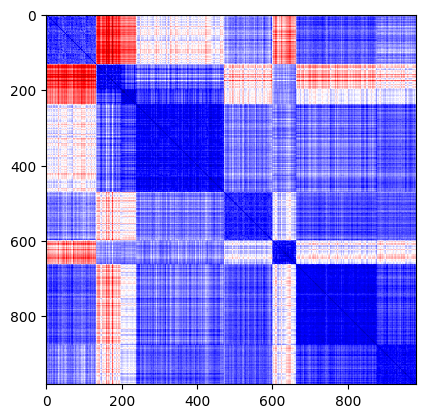

In [10]:
plt.imshow(norm_matrix,cmap='seismic')

In [46]:
matrix_colored = []


for i in range(100):
    temp = []
    for j in range(100):
        temp.append([255,0,0])
    matrix_colored.append(temp)

print(np.array(matrix_colored).shape)

(100, 100, 3)


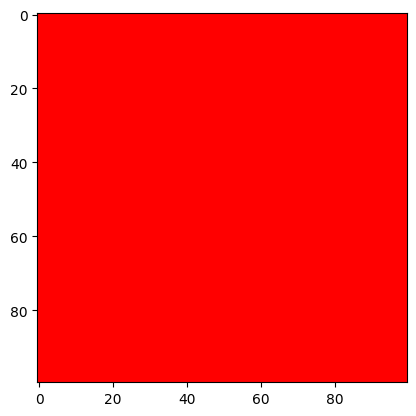

In [49]:
plt.imshow(matrix_colored)